In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
import numpy as np
import scanpy as sc
from pathlib import Path

In [2]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fm.fontManager.addfont('/work/magroup/skrieger/Arial.ttf')
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial']

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme(style="white")  


# Fixed consistent orders and fixed color palette
fg_order = ["ESM2", "Gene2Vec", "GenePT", "HyenaDNA", "Random"]
fe_order = ["Sorting", "Binning", "Autobin", "Continuous"]

# # Choose any color palette that supports 5 unique colors
# base_palette = sns.color_palette("Set2", 5)
# fg_color_map = {
#     "ESM2": base_palette[0],
#     "Gene2Vec": base_palette[1],
#     "GenePT": base_palette[2],
#     "HyenaDNA": base_palette[3],
#     "Random": base_palette[4]
# }
# Fixed consistent orders and color mapping
fg_order = ["ESM2", "Gene2Vec", "GenePT", "HyenaDNA", "Random"]
fe_order = ["Sorting", "Binning", "Autobin", "Continuous"]
base_palette = sns.color_palette("Set2", 5)
fg_color_map = dict(zip(fg_order, base_palette))

<h2>Preprocessing CSVs</h2>

In [3]:
def preprocess_csv_for_plotting(
    filepath,
    skip_first_rows=0,
    needs_split_marker=False,
    dataset_filter=None,
    remove_dummy=False
):
    df = pd.read_csv(filepath)

    if skip_first_rows > 0:
        df = df.iloc[skip_first_rows:].reset_index(drop=True)

    # Handle split marker if needed
    if needs_split_marker:
        df['Status'] = df['Status'].astype(str).str.strip()  # Ensure clean matching
        marker_idx = df.index[df['Status'] == 'RERUN WITH ZEROS'].tolist()
        if marker_idx:
            split_idx = marker_idx[0]
            df['All_Genes'] = False
            df.loc[split_idx:, 'All_Genes'] = True
        else:
            print("Warning: No 'RERUN WITH ZEROS' marker found. Defaulting to All_Genes=False.")
            df['All_Genes'] = False
    elif 'All_Genes' not in df.columns:
        df['All_Genes'] = False

    # Drop unneeded
    df = df.drop(columns=['Run Command', 'Create Sweep Command', 'Run/Sweep Command'], errors='ignore')

    # Mappings
    fe_map = {
        'nonzero_2nn': 'Continuous',
        'scfoundation': 'Autobin',
        'sorting': 'Sorting',
        'binning': 'Binning'
    }
    fg_map = {
        'identity': 'Random',
        'pca_esm2': 'ESM2',
        'pca_gene2vec': 'Gene2Vec',
        'pca_hyenadna': 'HyenaDNA',
        'pca_genept': 'GenePT'
    }
    dataset_map = {
        'Spatial35': 'Overlap35',
        'Spatial113': 'Overlap113',
        'spatial_cancer_split1': 'Overlap35',
        'spatial_cancer_split2': 'Overlap113'
    }

    # Replace values
    df['F_Expression'] = df['F_Expression'].replace(fe_map)
    df['F_Gene'] = df['F_Gene'].replace(fg_map)

    if 'Dataset' not in df.columns and 'Experiment Name' in df.columns:
        df['Dataset'] = df['Experiment Name'].map(dataset_map)
    else:
        df['Dataset'] = df['Dataset'].replace(dataset_map)

    df.columns = df.columns.astype(str)
    df['mcc'] = pd.to_numeric(df['Test Score'], errors='coerce')
    df = df.dropna(subset=['mcc'])

    # Rename for plotting
    df = df.rename(columns={'F_Gene': 'fg_tokenizer', 'F_Expression': 'fe_tokenizer'})

    # Filter for specific dataset if requested
    if dataset_filter is not None:
        print("Filtering for dataset:", dataset_filter)
        print("Available datasets:", df['Dataset'].unique())
        df = df[df['Dataset'] == dataset_filter]

    # Remove dummy rows if requested
    if remove_dummy:
        df = df[df['fg_tokenizer'] != 'dummy']

    # Return a dict of both splits
    return {
        False: df[df['All_Genes'] == False].copy(),
        True: df[df['All_Genes'] == True].copy()
    }


In [4]:
#Spatial split
df_overlap = preprocess_csv_for_plotting("/work/magroup/nzh/Heimdall-dev/plotting/spatial.csv",
    dataset_filter="Overlap35",
    remove_dummy=False
)


#Random split
df_random = preprocess_csv_for_plotting(
    filepath="/work/magroup/ehaber/heimdall_plotting/heimdall_overlap35-random.csv",
    skip_first_rows=3,
    needs_split_marker=True,
    dataset_filter="Overlap35",
    # all_genes_filter=False,
    remove_dummy=False
)


Filtering for dataset: Overlap35
Available datasets: ['Overlap35' 'Overlap113']
Filtering for dataset: Overlap35
Available datasets: ['Overlap35']


<h2>Panel B and Panel C</h2>

Saved: /work/magroup/ehaber/Overlap35_Expressed_Genes.png
Saved: /work/magroup/ehaber/Overlap35_Expressed_Genes.pdf


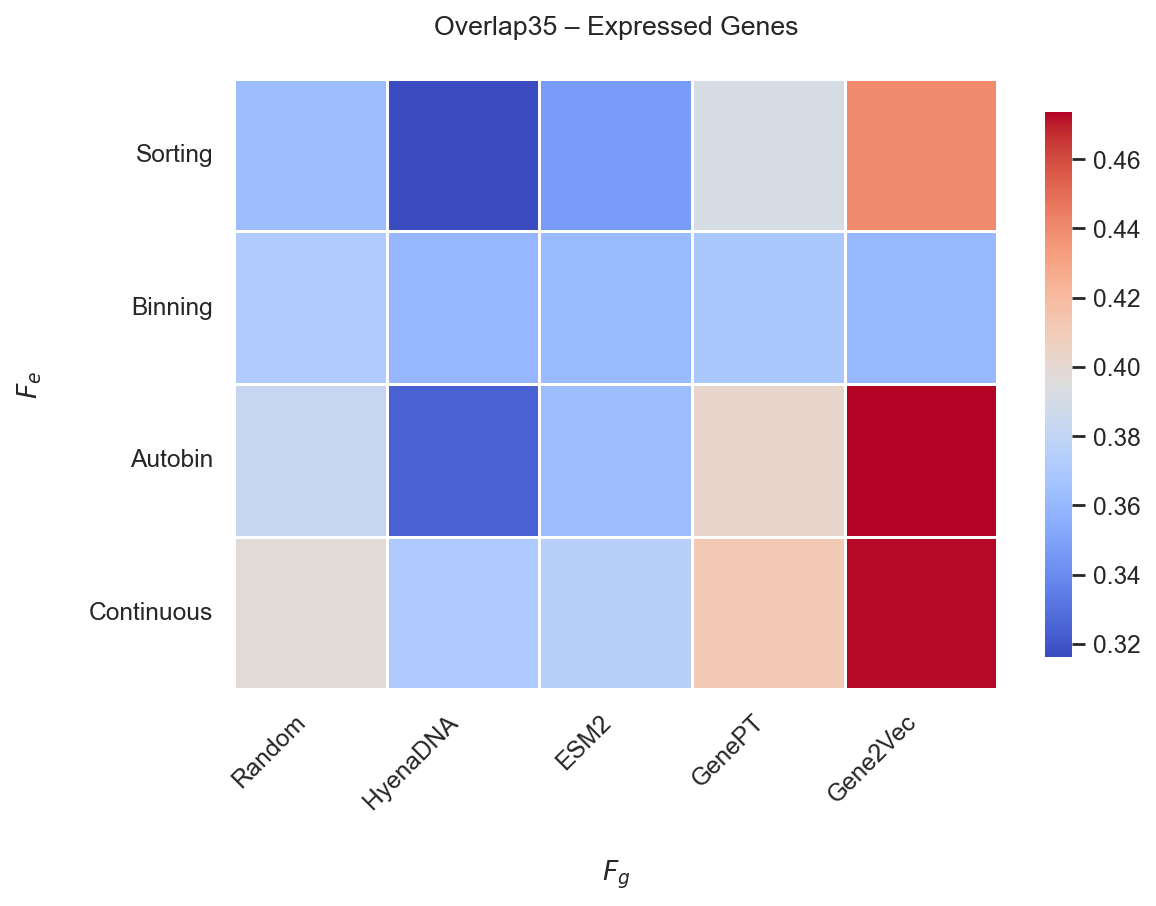

Saved: /work/magroup/ehaber/Overlap35_All_Genes.png
Saved: /work/magroup/ehaber/Overlap35_All_Genes.pdf


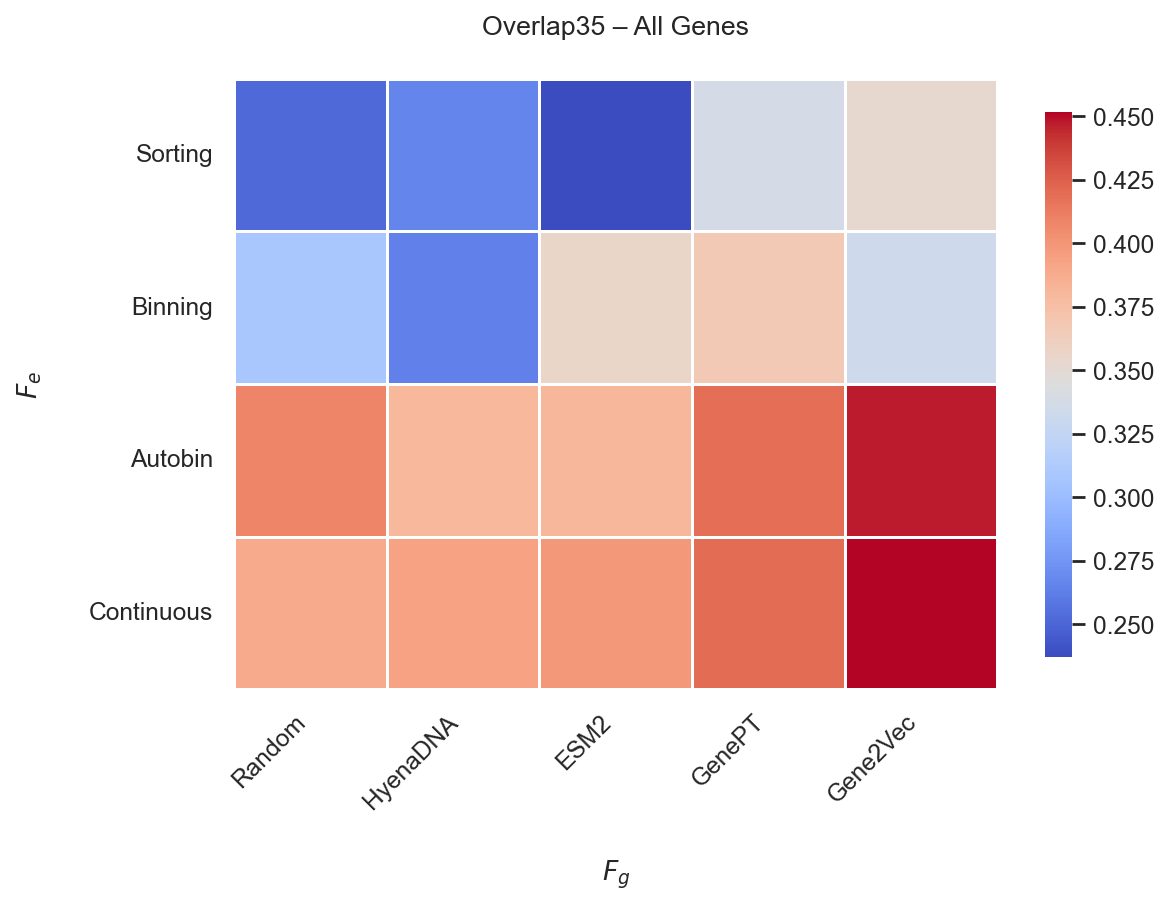

In [6]:
gene_order = ["Random", "HyenaDNA", "ESM2", "GenePT", "Gene2Vec"]
expression_order = ["Sorting", "Binning", "Autobin", "Continuous"]

def plot_heatmap(data, title, save_path=None):
    if data.empty:
        print(f"Skipping {title}: No data.")
        return

    grouped = data.groupby(['fg_tokenizer', 'fe_tokenizer']).agg(mean_value=('mcc', 'mean')).reset_index()
    pivot = grouped.pivot(index="fe_tokenizer", columns="fg_tokenizer", values="mean_value")

    pivot = pivot.loc[[fe for fe in expression_order if fe in pivot.index],
                      [fg for fg in gene_order if fg in pivot.columns]]

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        pivot, cmap="coolwarm", annot=False, linewidths=0.5, linecolor='white',
        cbar_kws={"shrink": 0.8, "aspect": 20}, ax=ax
    )

    ax.set_title(title, pad=20)
    ax.set_xlabel('$F_{g}$', labelpad=20)
    ax.set_ylabel('$F_{e}$', labelpad=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_aspect('equal', adjustable='box')

    plt.tight_layout(pad=2.0)
    if save_path:
        path_base = Path(save_path).with_suffix('')
        for ext in ['.png', '.pdf']:
            plt.savefig(f"{path_base}{ext}", dpi=300, bbox_inches='tight')
            print(f"Saved: {path_base}{ext}")
    plt.show()
    plt.close(fig)

#Plot both splits
for all_genes_flag, df_sub in df_overlap.items():
    label = "All Genes" if all_genes_flag else "Expressed Genes"
    for dataset in df_sub['Dataset'].unique():
        subset = df_sub[df_sub['Dataset'] == dataset]
        title = f"{dataset} – {label}"
        save_path = f"/work/magroup/ehaber/{dataset}_{label.replace(' ', '_')}"
        plot_heatmap(subset, title, save_path)

<h2>Panel F</h2>

In [7]:
def plot_split(df_dict, title_prefix, save_prefix):
    for all_genes, sub in df_dict.items():
        # print(f"\n[{title_prefix} | All_Genes = {all_genes}]")
        # print("Subset shape:", sub.shape)
        # print("Unique fg_tokenizer:", sub['fg_tokenizer'].unique())
        # print("Unique fe_tokenizer:", sub['fe_tokenizer'].unique())
        # print("Any NA in mcc:", sub['mcc'].isna().any())
        # print(sub.head())

        dummy_df = sub[sub['fg_tokenizer'] == 'dummy']
        dummy_mcc = dummy_df['mcc'].mean()
        sub = sub[sub['fg_tokenizer'] != 'dummy']

        plt.figure(figsize=(6, 6), facecolor='white')
        sns.barplot(
            data=sub,
            x='fe_tokenizer',
            y='mcc',
            hue='fg_tokenizer',
            order=fe_order,
            hue_order=fg_order,
            palette=fg_color_map,
            errorbar='sd',
            err_kws={"color": "black", "linewidth": 1.5},
            capsize=0.1
        )

        if not pd.isna(dummy_mcc):
            plt.axhline(dummy_mcc, color='red', linestyle='--', linewidth=2, label='Linear regression')

        plt.title(f"{title_prefix} – All_Genes={all_genes}")
        plt.xlabel("$F_e$")
        plt.ylabel("MCC")
        plt.legend(title="$F_g$", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()

        plt.savefig(f"{save_prefix}_allgenes_{all_genes}.png", dpi=300, facecolor='white')
        plt.savefig(f"{save_prefix}_allgenes_{all_genes}.pdf", facecolor='white')
        plt.show()


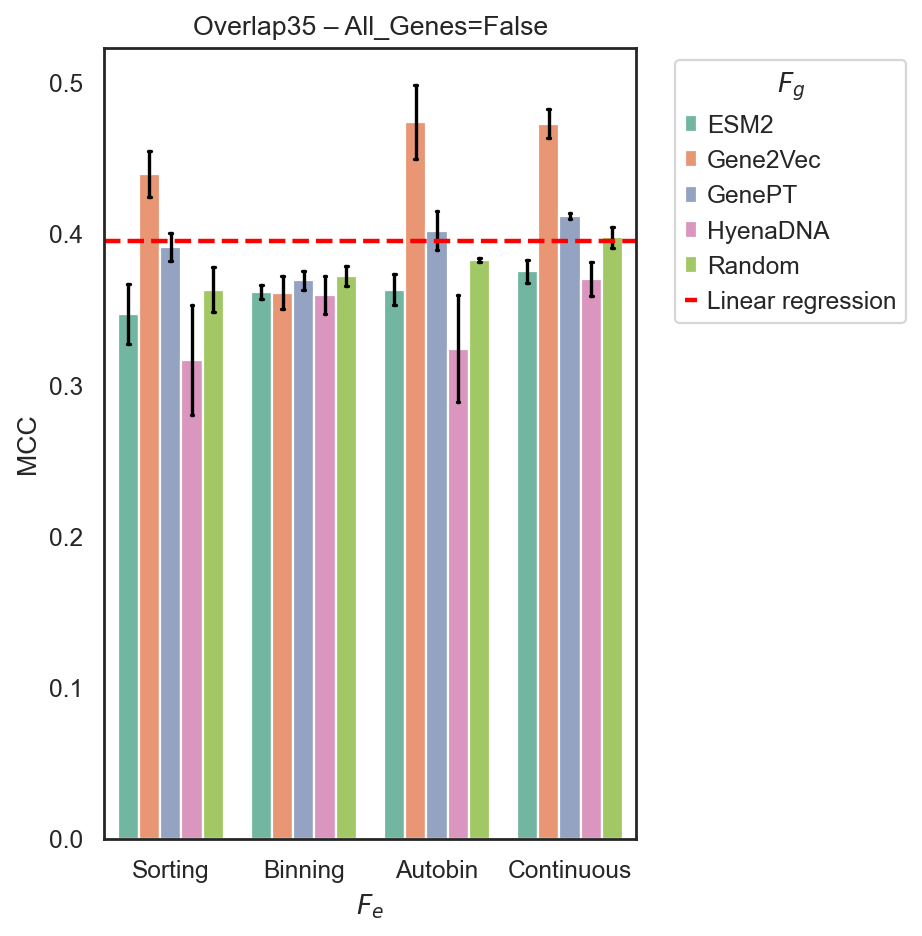

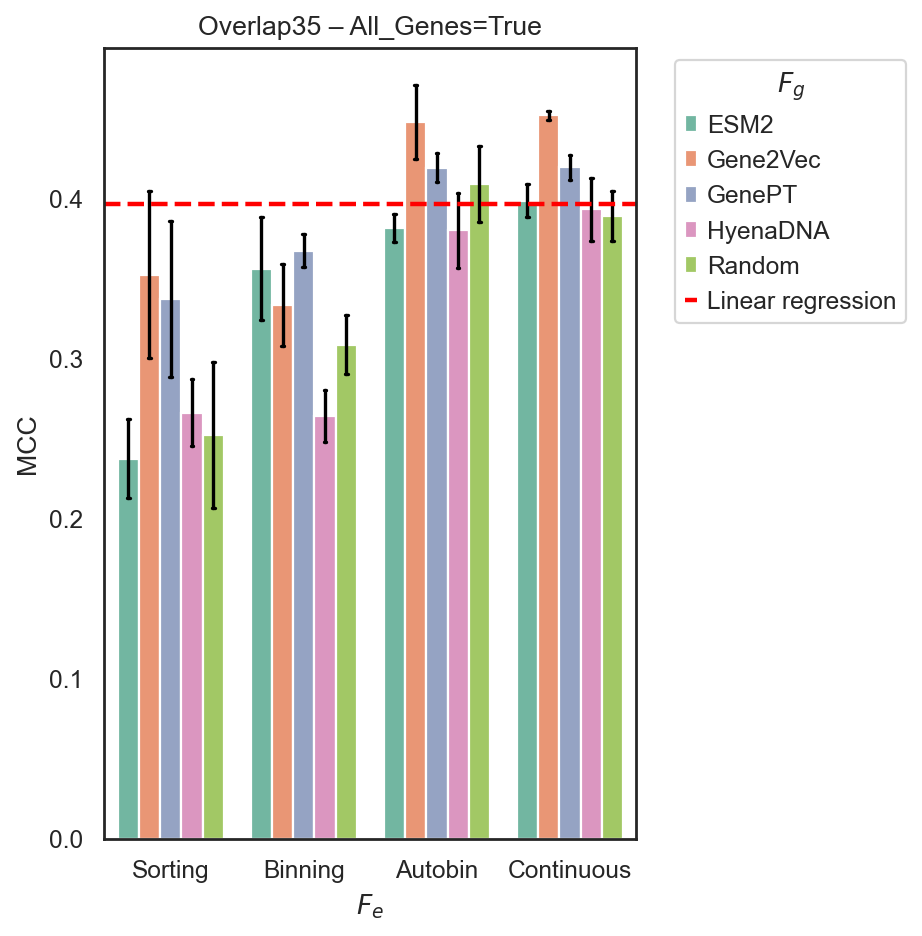

In [9]:
#All_Genes==False = Only expressed genes
#All_Genes==True = All genes

plot_split(df_overlap, title_prefix="Overlap35", save_prefix="/work/magroup/ehaber/")

<h2>Panel G</h2>

Filtering for dataset: Overlap35
Available datasets: ['Overlap35']


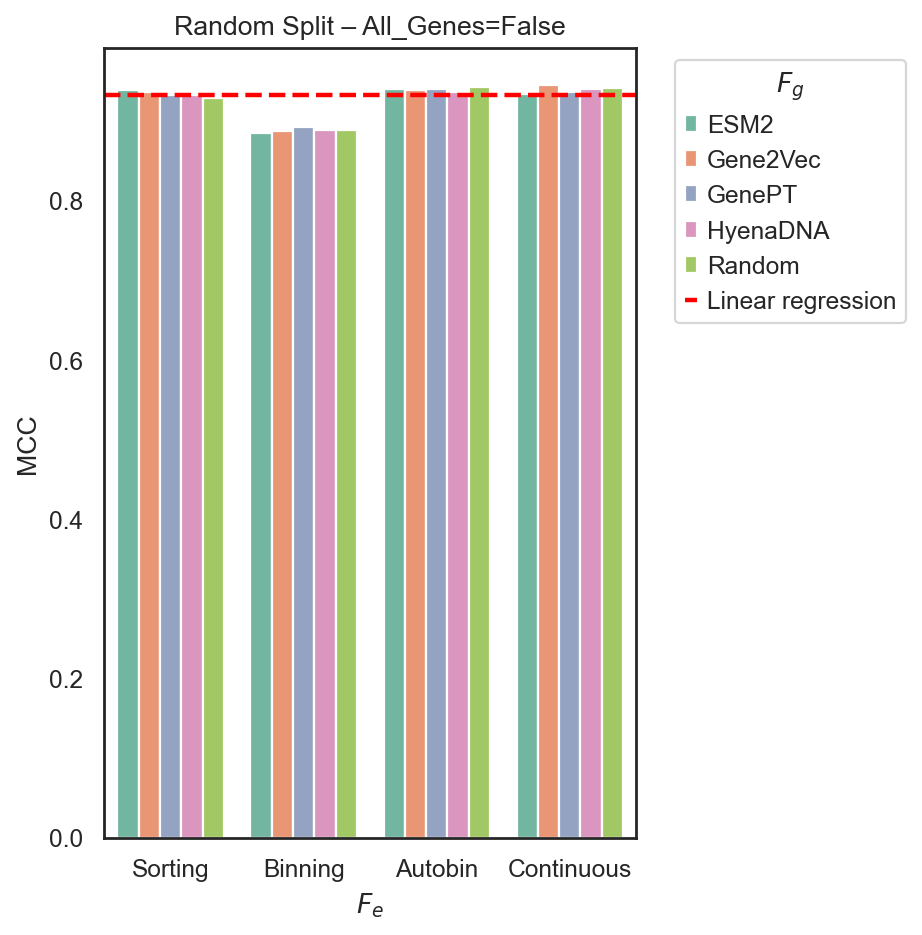

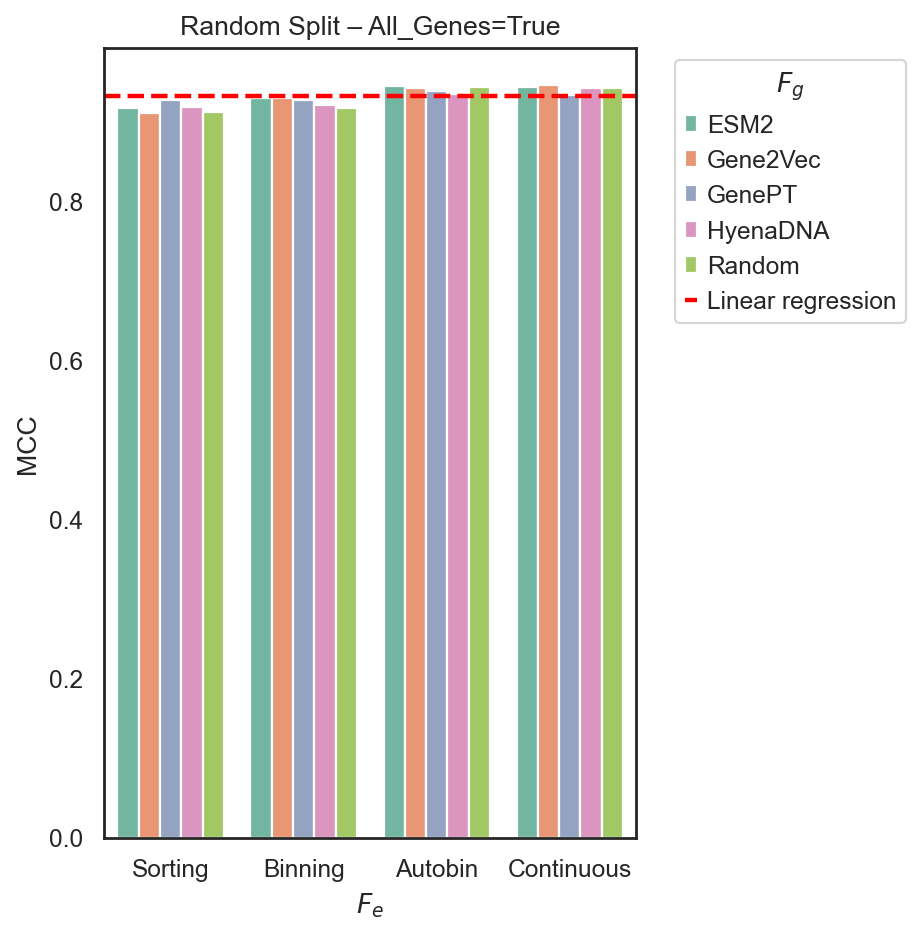

In [35]:
#All_Genes==False = Only expressed genes
#All_Genes==True = All genes

plot_split(df_random, title_prefix="Random Split", save_prefix="/path/to/dir/")
